In [6]:
import numpy as np
import time
from scipy.special import lambertw
from scipy.optimize import minimize

# System parameters (from paper Section IV)
N = 20  # Number of mobile users
h_c = 10e9  # Edge server computation ability (10 GHz)
h_n = np.random.choice([0.5e9, 0.6e9, 0.7e9, 0.8e9, 0.9e9, 1.0e9], N)  # Local CPU abilities
d_n = np.random.uniform(0, 2e6, N)  # Task data size (0-2 MB in bits)
c_n = 1000 * d_n  # Required CPU cycles (1000 cycles/bit)
B = 5e6  # Bandwidth (5 MHz)
N0 = 1e-12  # Noise power density (W/Hz)
E_n = np.random.choice([1.0, 1.5, 2.0], N)  # Energy constraints (Joules)
T_n = np.random.uniform(0.1, 0.5, N)  # Latency constraints (0.1-0.5 seconds)
g_n = np.random.uniform(0.1, 1.0, N)  # Channel gains
f_n = np.full(N, 1e-9)  # Local energy per cycle (J/cycle)
C = 0.7 * np.sum(c_n)  # Server capacity (70% of total required cycles)

# Helper functions
def h(x):
    return N0 * B * (2**(x/B) - 1)

def energy_off(alpha, r, n):
    return (d_n[n] * alpha / g_n[n]**2) * h(r) / r

def energy_local(alpha, n):
    return f_n[n] * c_n[n] * (1 - alpha)

def total_energy(alphas, rs):
    return sum(energy_off(alphas[n], rs[n], n) + energy_local(alphas[n], n) for n in range(N))

def latency_local(alpha, n):
    return c_n[n] * (1 - alpha) / h_n[n]

def latency_off(alpha, r, n):
    return (d_n[n] * alpha / r) + (c_n[n] * alpha / h_c)

def total_latency(alpha, r, n):
    return latency_local(alpha, n) + latency_off(alpha, r, n)

In [7]:
def primal_dual_optimize(max_iter=1000, gamma=0.1, tol=1e-4):
    start_time = time.time()
    # Initialize variables
    alphas = np.full(N, 0.5)
    rs = np.full(N, B/N)
    lambdas = np.zeros(N)
    mus = np.zeros(N)
    nu = 0
    eta = 0
    
    # Lambert W helper
    def lambert_solution(n, lambd, mu):
        z = -lambd * g_n[n]**2 / (N0 * B * np.exp(1) * (1 + mu * g_n[n]**2))
        arg = np.real(lambertw(z, k=0)) + 1
        return (B / np.log(2)) * arg

    # Optimization loop
    for iter in range(max_iter):
        # Update primal variables (simplified)
        for n in range(N):
            # Update transmission rate (from paper Eq. 22)
            rs[n] = lambert_solution(n, lambdas[n], mus[n])
            
            # Update offloading fraction (from paper Eq. 23)
            num = T_n[n] * h_n[n] * h_c - c_n[n] * h_c
            denom = h_c * h_n[n] * d_n[n] / rs[n] + c_n[n] * h_n[n] - c_n[n] * h_c
            alphas[n] = np.clip(num / denom, 0, 1) if denom != 0 else 0
        
        # Update dual variables
        for n in range(N):
            # Time constraint violation
            time_viol = total_latency(alphas[n], rs[n], n) - T_n[n]
            lambdas[n] = max(0, lambdas[n] + gamma * time_viol)
            
            # Energy constraint violation
            energy_viol = (energy_off(alphas[n], rs[n], n) + 
                          energy_local(alphas[n], n) - E_n[n])
            mus[n] = max(0, mus[n] + gamma * energy_viol)
        
        # Server capacity violation
        server_viol = np.sum(c_n * alphas) - C
        nu = max(0, nu + gamma * server_viol)
        
        # Bandwidth violation
        bw_viol = np.sum(rs) - B
        eta = max(0, eta + gamma * bw_viol)
        
        # Check convergence
        if iter > 10 and np.max(np.abs([time_viol, energy_viol, server_viol, bw_viol])) < tol:
            break
    
    return {
        'alphas': alphas,
        'rs': rs,
        'energy': total_energy(alphas, rs),
        'time': time.time() - start_time,
        'iterations': iter + 1
    }

In [8]:
def qpm_optimize(max_iter=1000, rho=1e3, rho_inc=2.0, tol=1e-4):
    start_time = time.time()
    # Initialize variables
    alphas = np.full(N, 0.5)
    rs = np.full(N, B/N)
    
    # Penalty function
    def penalty_objective(x):
        alphas = x[:N]
        rs = x[N:2*N]
        obj = total_energy(alphas, rs)
        
        # Penalties for constraints
        penalty = 0
        for n in range(N):
            # Time constraint
            time_viol = max(0, total_latency(alphas[n], rs[n], n) - T_n[n])
            # Energy constraint
            energy_viol = max(0, (energy_off(alphas[n], rs[n], n) + 
                               energy_local(alphas[n], n) - E_n[n]))
            penalty += time_viol**2 + energy_viol**2
        
        # Server capacity constraint
        server_viol = max(0, np.sum(c_n * alphas) - C)**2
        # Bandwidth constraint
        bw_viol = max(0, np.sum(rs) - B)**2
        
        return obj + rho * (penalty + server_viol + bw_viol)
    
    # Optimization loop
    prev_obj = float('inf')
    for iter in range(max_iter):
        res = minimize(penalty_objective, np.concatenate([alphas, rs]), 
                       bounds=[(0,1)]*N + [(1e-6, B)]*N)
        x = res.x
        alphas, rs = x[:N], x[N:2*N]
        
        # Check convergence
        obj_val = total_energy(alphas, rs)
        if abs(prev_obj - obj_val) < tol:
            break
        prev_obj = obj_val
        rho *= rho_inc
    
    return {
        'alphas': alphas,
        'rs': rs,
        'energy': total_energy(alphas, rs),
        'time': time.time() - start_time,
        'iterations': iter + 1
    }

In [11]:
# Run both methods
qpm_result = qpm_optimize()
pd_result = primal_dual_optimize()

# Print comparison
print(f"{'Metric':<25} {'QPM':<15} {'Primal-Dual':<15}")
print(f"{'-'*45}")
print(f"{'Computation time (s)':<25} {qpm_result['time']:<15.4f} {pd_result['time']:<15.4f}")
print(f"{'Iterations':<25} {qpm_result['iterations']:<15} {pd_result['iterations']:<15}")
print(f"{'Optimal energy (J)':<25} {qpm_result['energy']:<15.4f} {pd_result['energy']:<15.4f}")
print(f"{'Avg offloading fraction':<25} {np.mean(qpm_result['alphas']):<15.4f} {np.mean(pd_result['alphas']):<15.4f}")

# Constraint satisfaction check
def check_constraints(alphas, rs):
    time_sat = sum(total_latency(alphas[n], rs[n], n) <= T_n[n] for n in range(N))
    energy_sat = sum(energy_off(alphas[n], rs[n], n) + energy_local(alphas[n], n) <= E_n[n] for n in range(N))
    server_sat = np.sum(c_n * alphas) <= C
    bw_sat = np.sum(rs) <= B
    return {
        'time_sat': time_sat,
        'energy_sat': energy_sat,
        'server_sat': server_sat,
        'bw_sat': bw_sat
    }

print("\nConstraint Satisfaction:")
print(f"{'Metric':<15} {'QPM':<10} {'Primal-Dual':<10}")
for constr in ['time_sat', 'energy_sat', 'server_sat', 'bw_sat']:
    qpm_sat = check_constraints(qpm_result['alphas'], qpm_result['rs'])[constr]
    pd_sat = check_constraints(pd_result['alphas'], pd_result['rs'])[constr]
    print(f"{constr:<15} {str(qpm_sat):<10} {str(pd_sat):<10}")

Metric                    QPM             Primal-Dual    
---------------------------------------------
Computation time (s)      0.0676          0.2811         
Iterations                2               1000           
Optimal energy (J)        24.0876         1.0458         
Avg offloading fraction   0.0500          0.8729         

Constraint Satisfaction:
Metric          QPM        Primal-Dual
time_sat        1          14        
energy_sat      14         20        
server_sat      True       False     
bw_sat          True       False     


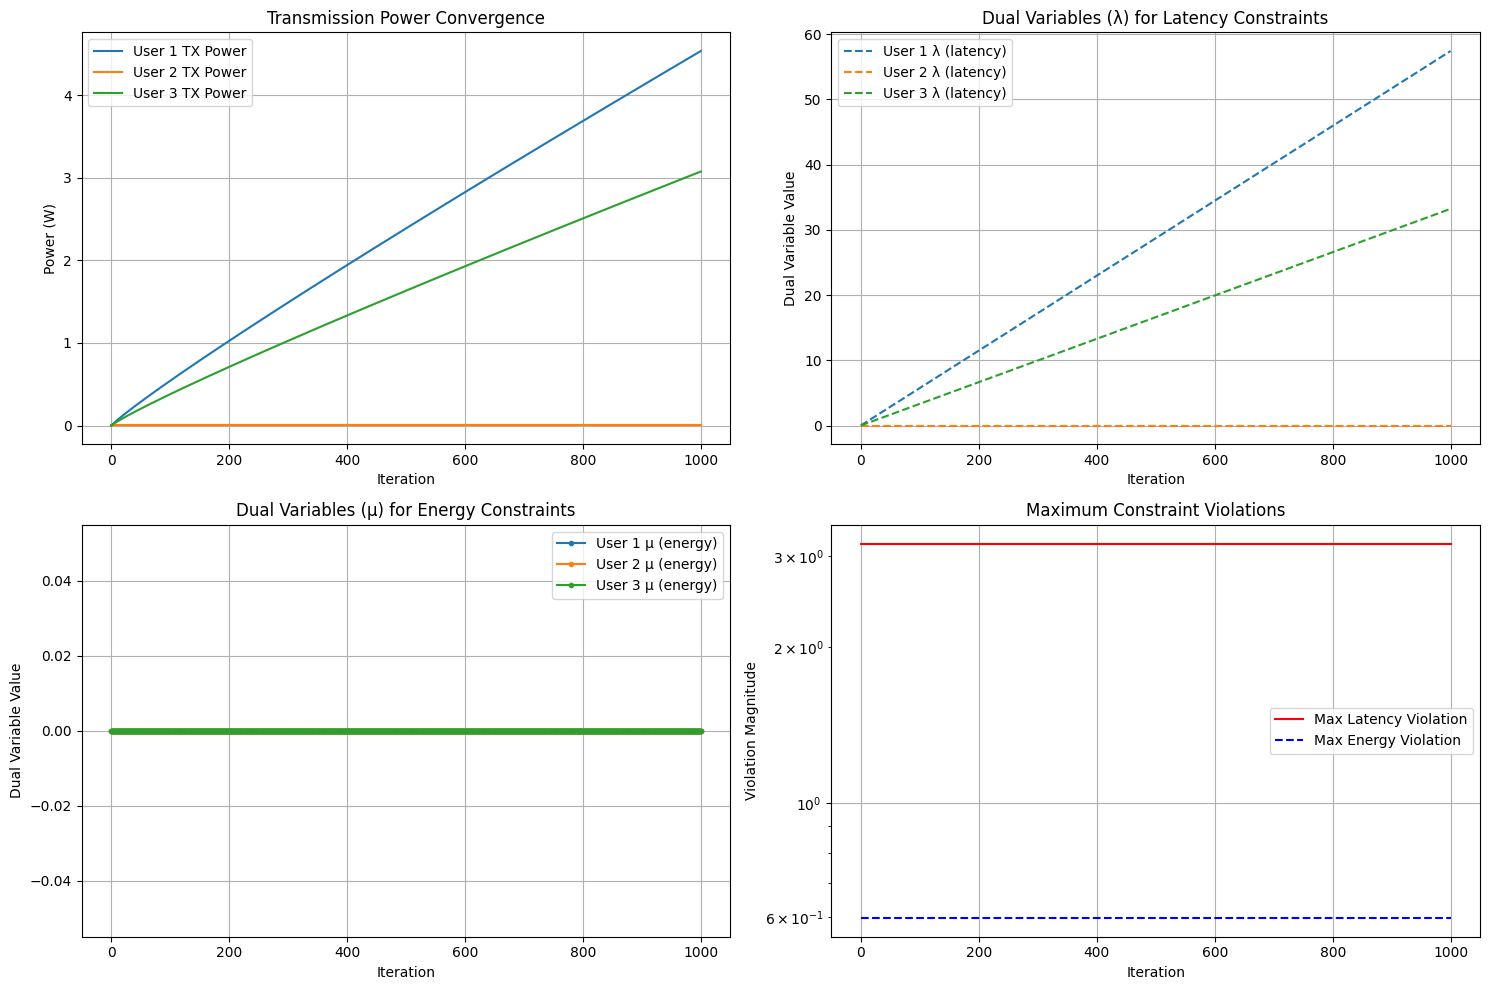

Optimization completed in 1000 iterations
Total energy consumption: 23.3482 Joules
Average offloading fraction: 0.0141
Computation time: 0.3771 seconds

Constraint Satisfaction:
User 1: Latency 1.4838s/0.3341s, Energy 0.8903J/1.5000J, Offload 0.00%
User 2: Latency 0.3848s/0.3848s, Energy 0.1368J/2.0000J, Offload 27.60%
User 3: Latency 1.1133s/0.4482s, Energy 1.1133J/2.0000J, Offload 0.00%
User 4: Latency 1.4249s/0.1138s, Energy 1.2824J/1.5000J, Offload 0.00%
User 5: Latency 1.2782s/0.1027s, Energy 0.8947J/2.0000J, Offload 0.00%
User 6: Latency 2.0342s/0.2548s, Energy 1.4240J/1.0000J, Offload 0.00%
User 7: Latency 0.9427s/0.2217s, Energy 0.8484J/1.5000J, Offload 0.00%
User 8: Latency 2.3252s/0.2774s, Energy 1.3951J/1.0000J, Offload 0.00%
User 9: Latency 2.6251s/0.3849s, Energy 1.8376J/2.0000J, Offload 0.00%
User 10: Latency 1.5888s/0.2933s, Energy 1.5888J/2.0000J, Offload 0.00%
User 11: Latency 3.1960s/0.2718s, Energy 1.5980J/1.0000J, Offload 0.00%
User 12: Latency 1.7634s/0.2039s, Ener

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
import time

# System parameters (from paper Section IV)
N = 20  # Number of mobile users
h_c = 10e9  # Edge server computation ability (10 GHz)
h_n = np.random.choice([0.5e9, 0.6e9, 0.7e9, 0.8e9, 0.9e9, 1.0e9], N)  # Local CPU abilities
d_n = np.random.uniform(0, 2e6, N)  # Task data size (0-2 MB in bits)
c_n = 1000 * d_n  # Required CPU cycles (1000 cycles/bit)
B = 5e6  # Bandwidth (5 MHz)
N0 = 1e-12  # Noise power density (W/Hz)
E_n = np.random.choice([1.0, 1.5, 2.0], N)  # Energy constraints (Joules)
T_n = np.random.uniform(0.1, 0.5, N)  # Latency constraints (0.1-0.5 seconds)
g_n = np.abs(np.random.normal(0, 1, N))  # Channel gains (absolute values)
f_n = np.full(N, 1e-9)  # Local energy per cycle (J/cycle)
C = 0.7 * np.sum(c_n)  # Server capacity (70% of total required cycles)

# Helper functions
def h(r):
    """Channel function from paper Eq. (2)"""
    return N0 * B * (2**(r/B) - 1)

def transmission_power(r, n):
    """Transmission power from paper Eq. (2)"""
    return h(r) / (g_n[n]**2)

def energy_off(alpha, r, n):
    """Offloading energy from paper Eq. (3)"""
    return (d_n[n] * alpha) * transmission_power(r, n) / r

def energy_local(alpha, n):
    """Local computation energy from paper Eq. (5)"""
    return f_n[n] * c_n[n] * (1 - alpha)

def total_energy(alphas, rs):
    """Total energy consumption from paper Eq. (7)"""
    return sum(energy_off(alphas[n], rs[n], n) + energy_local(alphas[n], n) for n in range(N))

def latency_local(alpha, n):
    """Local computation latency from paper Eq. (6)"""
    return c_n[n] * (1 - alpha) / h_n[n]

def latency_off(alpha, r, n):
    """Offloading latency from paper Eq. (4)"""
    return (d_n[n] * alpha / r) + (c_n[n] * alpha / h_c)

def total_latency(alpha, r, n):
    """Total latency from paper Eq. (8)"""
    return latency_local(alpha, n) + latency_off(alpha, r, n)

def primal_dual_optimize(max_iter=1000, gamma=0.1, tol=1e-4):
    """Primal-Dual optimization as described in paper Section III"""
    # Initialize variables
    alphas = np.full(N, 0.5)  # Offloading fractions
    rs = np.full(N, B/N)      # Transmission rates
    lambdas = np.zeros(N)     # Dual variables for latency constraints
    mus = np.zeros(N)         # Dual variables for energy constraints
    
    # Storage for convergence visualization
    history = {
        'alphas': np.zeros((max_iter, N)),
        'rs': np.zeros((max_iter, N)),
        'powers': np.zeros((max_iter, N)),
        'lambdas': np.zeros((max_iter, N)),
        'mus': np.zeros((max_iter, N)),
        'energy': np.zeros(max_iter),
        'time_violation': np.zeros((max_iter, N)),
        'energy_violation': np.zeros((max_iter, N))
    }
    
    start_time = time.time()
    
    # Lambert W helper function
    def lambert_solution(n, lambd, mu):
        """Compute optimal rate using Lambert W function from paper Eq. (22)"""
        z_val = lambd * g_n[n]**2 / (N0 * B * np.exp(1) * (1 + mu * g_n[n]**2))
        # Handle negative values for Lambert W
        z_val = np.maximum(z_val, -1/np.exp(1) + 1e-6)
        arg = np.real(lambertw(z_val, k=0)) + 1
        return (B / np.log(2)) * arg
    
    # Optimization loop
    for iter in range(max_iter):
        # Store current values
        history['alphas'][iter] = alphas.copy()
        history['rs'][iter] = rs.copy()
        history['powers'][iter] = [transmission_power(r, n) for n, r in enumerate(rs)]
        history['lambdas'][iter] = lambdas.copy()
        history['mus'][iter] = mus.copy()
        history['energy'][iter] = total_energy(alphas, rs)
        
        # Update primal variables
        for n in range(N):
            # Update transmission rate (paper Eq. 22)
            if lambdas[n] > 0 or mus[n] > 0:
                rs[n] = lambert_solution(n, lambdas[n], mus[n])
            
            # Update offloading fraction (paper Eq. 23)
            num = T_n[n] * h_n[n] * h_c - c_n[n] * h_c
            denom = h_c * h_n[n] * d_n[n] / max(rs[n], 1e-6) + c_n[n] * h_n[n] - c_n[n] * h_c
            alphas[n] = np.clip(num / max(denom, 1e-6), 0, 1)
        
        # Update dual variables
        for n in range(N):
            # Calculate constraint violations
            time_viol = max(0, total_latency(alphas[n], rs[n], n) - T_n[n])
            energy_viol = max(0, (energy_off(alphas[n], rs[n], n) + 
                              energy_local(alphas[n], n) - E_n[n]))
            
            history['time_violation'][iter, n] = time_viol
            history['energy_violation'][iter, n] = energy_viol
            
            # Update dual variables (gradient ascent)
            lambdas[n] = max(0, lambdas[n] + gamma * time_viol)
            mus[n] = max(0, mus[n] + gamma * energy_viol)
        
        # Check convergence
        if iter > 10 and np.max(history['time_violation'][iter]) < tol and \
           np.max(history['energy_violation'][iter]) < tol:
            break
    
    # Trim unused iterations
    for key in history:
        history[key] = history[key][:iter+1]
    
    return {
        'alphas': alphas,
        'rs': rs,
        'energy': total_energy(alphas, rs),
        'time': time.time() - start_time,
        'iterations': iter + 1,
        'history': history
    }

# Run optimization
result = primal_dual_optimize(max_iter=1000, gamma=0.05)
history = result['history']

# Visualization
plt.figure(figsize=(15, 10))

# Plot transmission power for first 3 users
plt.subplot(2, 2, 1)
for n in range(3):
    plt.plot(history['powers'][:, n], label=f'User {n+1} TX Power')
plt.title('Transmission Power Convergence')
plt.xlabel('Iteration')
plt.ylabel('Power (W)')
plt.grid(True)
plt.legend()

# Plot dual variables (λ) for latency constraints
plt.subplot(2, 2, 2)
for n in range(3):
    plt.plot(history['lambdas'][:, n], '--', label=f'User {n+1} λ (latency)')
plt.title('Dual Variables (λ) for Latency Constraints')
plt.xlabel('Iteration')
plt.ylabel('Dual Variable Value')
plt.grid(True)
plt.legend()

# Plot dual variables (μ) for energy constraints
plt.subplot(2, 2, 3)
for n in range(3):
    plt.plot(history['mus'][:, n], '.-', label=f'User {n+1} μ (energy)')
plt.title('Dual Variables (μ) for Energy Constraints')
plt.xlabel('Iteration')
plt.ylabel('Dual Variable Value')
plt.grid(True)
plt.legend()

# Plot constraint violations
plt.subplot(2, 2, 4)
max_time_viol = np.max(history['time_violation'], axis=1)
max_energy_viol = np.max(history['energy_violation'], axis=1)
plt.semilogy(max_time_viol, 'r-', label='Max Latency Violation')
plt.semilogy(max_energy_viol, 'b--', label='Max Energy Violation')
plt.title('Maximum Constraint Violations')
plt.xlabel('Iteration')
plt.ylabel('Violation Magnitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print optimization results
print(f"Optimization completed in {result['iterations']} iterations")
print(f"Total energy consumption: {result['energy']:.4f} Joules")
print(f"Average offloading fraction: {np.mean(result['alphas']):.4f}")
print(f"Computation time: {result['time']:.4f} seconds")

# Final constraint satisfaction
print("\nConstraint Satisfaction:")
for n in range(N):
    latency = total_latency(result['alphas'][n], result['rs'][n], n)
    energy = energy_off(result['alphas'][n], result['rs'][n], n) + energy_local(result['alphas'][n], n)
    print(f"User {n+1}: Latency {latency:.4f}s/{T_n[n]:.4f}s, "
          f"Energy {energy:.4f}J/{E_n[n]:.4f}J, "
          f"Offload {result['alphas'][n]:.2%}")

In [30]:
import numpy as np
from scipy.special import lambertw
import time

# Parameters from Section IV
N = 20                      # Number of mobile users
h_c = 10e9                  # MEC CPU speed (10 GHz)
h_n = np.random.uniform(0.5e9, 1.0e9, N)  # Local CPU speeds (0.5-1.0 GHz)
d_n = np.random.uniform(0, 2e6, N)        # Task sizes (0-2 MB)
c_n = 1000 * d_n            # CPU cycles (1000 cycles/bit)
B = 5e6                     # Bandwidth (5 MHz)
N0 = 1e-12                  # Noise power (W/Hz)
g_n = np.random.exponential(1, N)  # Channel gains (random)
f_n = np.random.uniform(1e-9, 2e-9, N)  # Local energy per cycle (J/cycle)
T_n = np.random.uniform(0.1, 0.5, N)     # Latency requirements (100-500 ms)
E_n = np.random.choice([1, 1.5, 2], N)   # Energy budgets (1-2 J)
C = 50e9                    # Server capacity (50 GHz)

# Lambert W function for optimal rate (Eq. 22)
def compute_optimal_rate(lambda_, mu, g_n):
    x = (lambda_ * g_n**2) / (N0 * B * np.e * (1 + mu * g_n**2)) - 1/np.e
    r_n = (B / np.log(2)) * (np.real(lambertw(x)) + 1)
    return np.maximum(r_n, 1e-6)  # Avoid zero rates

# Primal-dual algorithm
def primal_dual_solution(max_iter=1000, tol=1e-4, step_size=0.01):
    # Initialize dual variables
    lambda_ = np.ones(N)    # Lagrange multipliers for latency
    mu = np.ones(N)         # Lagrange multipliers for energy
    alpha = np.zeros(N)     # Offloading fractions
    r_n = np.zeros(N)       # Transmission rates
    
    prev_obj = np.inf
    history = []
    start_time = time.time()
    
    for iter_ in range(max_iter):
        # Step 1: Compute optimal rates (Eq. 22)
        r_n = compute_optimal_rate(lambda_, mu, g_n)
        
        # Step 2: Compute optimal alpha (Eq. 23)
        numerator = T_n * h_n * h_c - c_n * h_c
        denominator = h_c * h_n * d_n / r_n + c_n * h_n - c_n * h_c
        alpha = np.clip(numerator / denominator, 0, 1)
        
        # Step 3: Compute primal objective (Eq. 9)
        e_off = (d_n * (N0 * B * (2**(r_n/B) - 1)) / (g_n**2 * r_n) * alpha)
        e_loc = f_n * c_n * (1 - alpha)
        obj = np.sum(e_off + e_loc)
        
        # Step 4: Compute constraints
        t_off = (d_n / r_n) + (c_n / h_c)
        t_all = (c_n / h_n) * (1 - alpha) + t_off * alpha
        e_all = e_off + e_loc
        
        # Step 5: Update dual variables (gradient ascent)
        lambda_ += step_size * np.maximum(t_all - T_n, 0)
        mu += step_size * np.maximum(e_all - E_n, 0)
        lambda_ = np.maximum(lambda_, 0)
        mu = np.maximum(mu, 0)
        
        # Check convergence
        history.append(obj)
        if iter_ > 10 and np.abs(prev_obj - obj) < tol:
            break
        prev_obj = obj
    
    comp_time = time.time() - start_time
    return alpha, r_n, obj, iter_ + 1, comp_time, history

# Run the algorithm
alpha_opt, r_n_opt, obj_opt, iterations, comp_time, history = primal_dual_solution()

# Output results
print(f"Optimal offloading fractions (α_n):\n{alpha_opt.round(4)}")
print(f"\nOptimal transmission rates (r_n) [bps]:\n{r_n_opt.round(2)}")
print(f"\nOptimal objective value (total energy): {obj_opt:.2f} J")
print(f"Iterations to converge: {iterations}")
print(f"Computation time: {comp_time:.4f} seconds")

Optimal offloading fractions (α_n):
[0.5054 0.949  0.5584 0.9443 0.5529 0.9279 0.9714 0.2223 0.1948 0.9542
 0.8766 0.8395 1.     0.846  0.8487 0.4324 0.8224 0.9725 0.9991 0.4661]

Optimal transmission rates (r_n) [bps]:
[63928758.65 71483051.61 49265876.8  66852316.55 65075256.03 67335643.46
 24073740.12 70815819.66 71352256.06 66422177.18 68745828.94 71269092.74
 68937604.95 49196629.95 66652652.96 67247314.86 62821667.26 69301708.85
 71371640.67 71295685.88]

Optimal objective value (total energy): 4.40 J
Iterations to converge: 12
Computation time: 0.0077 seconds


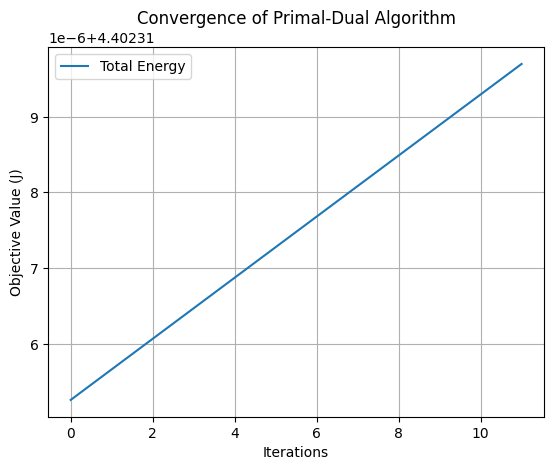

In [31]:
import matplotlib.pyplot as plt
plt.plot(history, label='Total Energy')
plt.xlabel('Iterations')
plt.ylabel('Objective Value (J)')
plt.title('Convergence of Primal-Dual Algorithm')
plt.legend()
plt.grid()
plt.show()

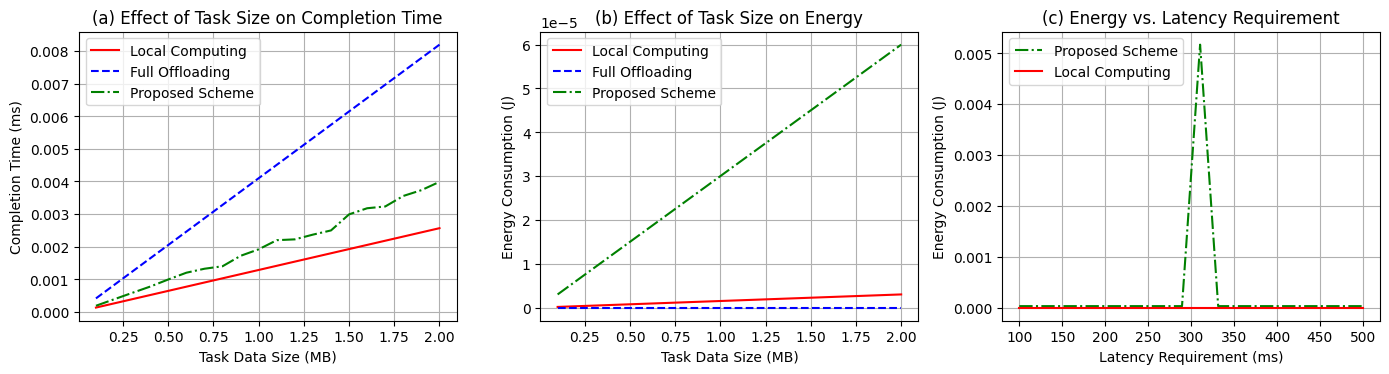

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw

# Fixed parameters (from Section IV)
N = 20                      # Number of users
h_c = 10e9                  # MEC CPU speed (10 GHz)
B = 5e6                     # Bandwidth (5 MHz)
N0 = 1e-12                  # Noise power (W/Hz)
f_n = 1.5e-9 * np.ones(N)   # Local energy per cycle (1.5e-9 J/cycle)
C = 50e9                    # Server capacity (50 GHz)

# Varying parameters for plots
task_sizes = np.linspace(0.1, 2, 20)  # Task sizes (0.1-2 MB)
latency_reqs = np.linspace(0.1, 0.5, 20)  # Latency (100-500 ms)

# Helper functions
def compute_optimal_rate(lambda_, mu, g_n):
    x = (lambda_ * g_n**2) / (N0 * B * np.e * (1 + mu * g_n**2)) - 1/np.e
    r_n = (B / np.log(2)) * (np.real(lambertw(x)) + 1)
    return np.maximum(r_n, 1e-6)

def solve_optimization(d_n, h_n, T_n, E_n, g_n):
    lambda_ = np.ones(N)
    mu = np.ones(N)
    alpha = np.zeros(N)
    r_n = np.zeros(N)
    
    for _ in range(1000):  # Simplified for plotting
        r_n = compute_optimal_rate(lambda_, mu, g_n)
        numerator = T_n * h_n * h_c - (1000 * d_n) * h_c
        denominator = h_c * h_n * d_n / r_n + (1000 * d_n) * (h_n - h_c)
        alpha = np.clip(numerator / denominator, 0, 1)
        
        # Update dual variables (gradient steps)
        t_off = (d_n / r_n) + (1000 * d_n / h_c)
        t_all = (1000 * d_n / h_n) * (1 - alpha) + t_off * alpha
        e_off = (d_n * (N0 * B * (2**(r_n/B) - 1)) / (g_n**2 * r_n) * alpha)
        e_loc = f_n * (1000 * d_n) * (1 - alpha)
        e_all = e_off + e_loc
        
        lambda_ += 0.01 * np.maximum(t_all - T_n, 0)
        mu += 0.01 * np.maximum(e_all - E_n, 0)
        lambda_ = np.maximum(lambda_, 0)
        mu = np.maximum(mu, 0)
    
    return alpha, np.sum(e_all), np.max(t_all)

# Generate data for plots
def generate_plot_data():
    # Define h_n here (local CPU speeds)
    h_n = np.random.uniform(0.5e9, 1.0e9, N)  # Local CPU speeds (0.5-1.0 GHz)
    
    # Local computing baseline
    local_time = [1000 * d / np.mean(h_n) * 1e3 for d in task_sizes]  # ms
    local_energy = [f_n[0] * 1000 * d for d in task_sizes]            # Joules
    
    # Full offloading baseline
    g_n = np.ones(N) * 0.5  # Fixed channel gain for simplicity
    full_offload_time = []
    full_offload_energy = []
    for d in task_sizes:
        r_n = B / N  # Equal bandwidth split
        t_comm = d / r_n * 1e3  # ms
        t_comp = (1000 * d / h_c) * 1e3  # ms
        full_offload_time.append(t_comm + t_comp)
        e_off = (d * (N0 * B * (2**(r_n/B) - 1)) / (g_n[0]**2 * r_n))
        full_offload_energy.append(e_off)
    
    # Proposed scheme (varying task size)
    proposed_time = []
    proposed_energy = []
    for d in task_sizes:
        h_n = np.random.uniform(0.5e9, 1.0e9, N)  # Re-randomize for each task
        g_n = np.random.exponential(1, N)
        T_n = np.random.uniform(0.1, 0.5, N)
        E_n = np.random.choice([1, 1.5, 2], N)
        _, e, t = solve_optimization(d * np.ones(N), h_n, T_n, E_n, g_n)
        proposed_time.append(t * 1e3)  # ms
        proposed_energy.append(e)
    
    # Proposed scheme (varying latency)
    fixed_d = 1.0  # Fixed task size (1 MB)
    proposed_energy_latency = []
    for T in latency_reqs:
        h_n = np.random.uniform(0.5e9, 1.0e9, N)
        g_n = np.random.exponential(1, N)
        E_n = np.random.choice([1, 1.5, 2], N)
        _, e, _ = solve_optimization(fixed_d * np.ones(N), h_n, T * np.ones(N), E_n, g_n)
        proposed_energy_latency.append(np.mean(e))
    
    return (local_time, local_energy, full_offload_time, full_offload_energy,
            proposed_time, proposed_energy, proposed_energy_latency)

# Plotting
def plot_results(data):
    local_time, local_energy, full_offload_time, full_offload_energy, \
    proposed_time, proposed_energy, proposed_energy_latency = data
    
    # Plot 1: Completion Time vs. Task Size (Fig. 2a)
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.plot(task_sizes, local_time, 'r-', label='Local Computing')
    plt.plot(task_sizes, full_offload_time, 'b--', label='Full Offloading')
    plt.plot(task_sizes, proposed_time, 'g-.', label='Proposed Scheme')
    plt.xlabel('Task Data Size (MB)')
    plt.ylabel('Completion Time (ms)')
    plt.title('(a) Effect of Task Size on Completion Time')
    plt.grid()
    plt.legend()
    
    # Plot 2: Energy vs. Task Size (Fig. 2b)
    plt.subplot(1, 3, 2)
    plt.plot(task_sizes, local_energy, 'r-', label='Local Computing')
    plt.plot(task_sizes, full_offload_energy, 'b--', label='Full Offloading')
    plt.plot(task_sizes, proposed_energy, 'g-.', label='Proposed Scheme')
    plt.xlabel('Task Data Size (MB)')
    plt.ylabel('Energy Consumption (J)')
    plt.title('(b) Effect of Task Size on Energy')
    plt.grid()
    plt.legend()
    
    # Plot 3: Energy vs. Latency (Fig. 2c)
    plt.subplot(1, 3, 3)
    plt.plot(latency_reqs * 1e3, proposed_energy_latency, 'g-.', label='Proposed Scheme')
    plt.plot(latency_reqs * 1e3, [np.mean(local_energy)] * len(latency_reqs), 'r-', label='Local Computing')
    plt.xlabel('Latency Requirement (ms)')
    plt.ylabel('Energy Consumption (J)')
    plt.title('(c) Energy vs. Latency Requirement')
    plt.grid()
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Generate and plot
data = generate_plot_data()
plot_results(data)

Optimal offloading fractions (α_n):
[0.5914 0.5472 0.7019 0.6944 0.5947 0.6231 0.3736 0.4447 0.5895 0.5053
 0.5036 0.5785 0.473  0.7239 0.6284 0.6428 0.647  0.6176 0.3392 0.7971]

Optimal transmission rates (r_n) [bps]:
[224950.31 250000.   227438.46 250000.   221520.45 250000.   250000.
 250000.   250000.   250000.   232434.58 223389.69 221088.62 250000.
 250000.   244057.35 213240.46 238225.23 250000.   245440.32]

Optimal objective value (total energy): 12.20 J
Iterations to converge: 100
Computation time: 0.2089 seconds


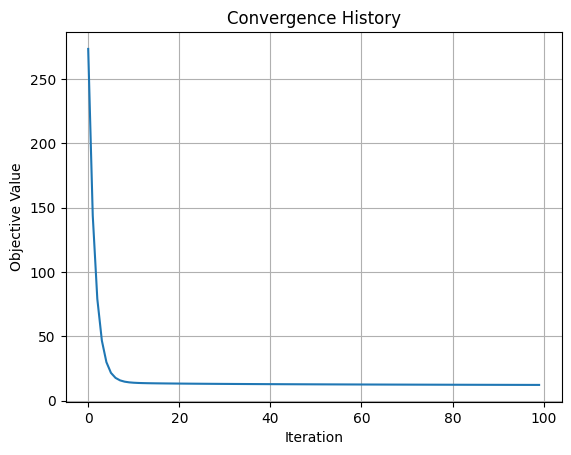

In [ ]:
import numpy as np
from scipy.linalg import solve
import time

# Parameters
N = 20
h_c = 10e9
h_n = np.random.uniform(0.5e9, 1.0e9, N)
d_n = np.random.uniform(0.1, 2, N) * 1e6
c_n = 1000 * d_n
B = 5e6
N0 = 1e-12
g_n = np.abs(np.random.normal(1, 0.1, N))  # Ensure positive channel gains
f_n = np.random.uniform(1e-9, 2e-9, N)
T_n = np.random.uniform(0.1, 0.5, N)
E_n = np.random.choice([1, 1.5, 2], N)
C = 50e9

def initialize_variables():
    """Initialize with feasible starting point"""
    alpha = np.clip(0.5 * np.ones(N) + 0.1 * np.random.randn(N), 0.1, 0.9)
    r_n = np.clip(B/N * np.ones(N) * (0.8 + 0.4*np.random.rand(N)), B/(2*N), B/N)
    return alpha, r_n

def compute_slacks(alpha, r_n):
    """Compute all slack variables with safeguards"""
    t_all = (c_n / h_n) * (1 - alpha) + (d_n / r_n + c_n / h_c) * alpha
    e_all = (d_n * (N0*B*(2**(r_n/B)-1)) / (g_n**2 * r_n)) * alpha + f_n * c_n * (1 - alpha)
    s_C = C - np.sum(c_n * alpha)
    s_B = B - np.sum(r_n)
    
    # Add small epsilon to prevent log(0)
    eps = 1e-10
    s_t = np.maximum(T_n - t_all, eps)
    s_e = np.maximum(E_n - e_all, eps)
    s_C = max(s_C, eps)
    s_B = max(s_B, eps)
    
    return s_t, s_e, s_C, s_B, t_all, e_all

def barrier_objective(alpha, r_n, mu):
    s_t, s_e, s_C, s_B, _, _ = compute_slacks(alpha, r_n)
    
    # Objective terms
    energy = np.sum((d_n * (N0*B*(2**(r_n/B)-1)) / (g_n**2 * r_n)) * alpha + f_n * c_n * (1 - alpha))
    
    # Barrier terms
    barrier = -mu * (np.sum(np.log(s_t)) + np.sum(np.log(s_e)) + np.log(s_C) + np.log(s_B))
    
    return energy + barrier

def compute_gradient(alpha, r_n, mu, eps=1e-6):
    grad = np.zeros(2*N)
    base_obj = barrier_objective(alpha, r_n, mu)
    
    # Compute gradient for alpha
    for i in range(N):
        alpha_eps = alpha.copy()
        alpha_eps[i] += eps
        grad[i] = (barrier_objective(alpha_eps, r_n, mu) - base_obj) / eps
    
    # Compute gradient for r_n
    for i in range(N):
        r_n_eps = r_n.copy()
        r_n_eps[i] += eps
        grad[N+i] = (barrier_objective(alpha, r_n_eps, mu) - base_obj) / eps
    
    return grad

def ipm_lb_solver(max_iter=100, tol=1e-4, mu_init=1.0, mu_decay=0.5):
    alpha, r_n = initialize_variables()
    mu = mu_init
    history = []
    start_time = time.time()
    
    for iter_ in range(max_iter):
        # Compute gradient
        grad = compute_gradient(alpha, r_n, mu)
        
        # Simple gradient descent with adaptive step size
        step_size = 0.01 / (iter_ + 1)
        delta = -grad * step_size
        
        # Apply update with projection
        alpha_new = np.clip(alpha + delta[:N], 0.01, 0.99)
        r_n_new = np.clip(r_n + delta[N:], B/(10*N), B/N)
        
        # Check if improvement
        new_obj = barrier_objective(alpha_new, r_n_new, mu)
        if new_obj < barrier_objective(alpha, r_n, mu) or iter_ < 10:
            alpha, r_n = alpha_new, r_n_new
        
        # Update barrier parameter
        mu *= mu_decay
        
        # Track progress
        obj = barrier_objective(alpha, r_n, mu)
        history.append(obj)
        
        if iter_ > 10 and np.abs(history[-1] - history[-2]) < tol:
            break
    
    comp_time = time.time() - start_time
    
    # Final feasibility check
    s_t, s_e, s_C, s_B, t_all, e_all = compute_slacks(alpha, r_n)
    if np.any(t_all > T_n + 1e-3) or np.any(e_all > E_n + 1e-3):
        print("Warning: Some constraints may be violated")
    
    return alpha, r_n, obj, iter_ + 1, comp_time, history

# Solve
alpha_opt, r_n_opt, obj_opt, iterations, comp_time, history = ipm_lb_solver()

# Output
print(f"Optimal offloading fractions (α_n):\n{alpha_opt.round(4)}")
print(f"\nOptimal transmission rates (r_n) [bps]:\n{r_n_opt.round(2)}")
print(f"\nOptimal objective value (total energy): {obj_opt:.2f} J")
print(f"Iterations to converge: {iterations}")
print(f"Computation time: {comp_time:.4f} seconds")

# Plot convergence
import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Convergence History')
plt.grid()
plt.show()

In [41]:
import cvxpy as cp
print("lmao")

lmao


In [49]:
import cvxpy as cp

print("Installed solvers:", cp.installed_solvers())


Installed solvers: ['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']


In [10]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# ======================
# Parameters for 2 Users
# ======================
N = 2  # Two users
h_edge = 10e9  # Edge server CPU (10 GHz)
B = 5e6  # Total bandwidth (5 MHz)
N0 = 1e-12  # Noise power density

# Fixed parameters for two users
h_local = np.array([0.8e9, 1.0e9])  # Local CPU
d = np.array([0.5, 1.0])  # Task sizes (MB)
c = 1000 * d * 8e6  # CPU cycles (1000 cycles/bit)
f = np.array([1e-9, 1e-9])  # Energy per cycle
g = np.array([1.2, 0.8])  # Channel gains
T_max = np.array([0.3, 0.4])  # Latency constraints
E_max = np.array([1.5, 2.0])  # Energy constraints

# ======================
# DCP-Compliant Problem Formulation
# ======================
alpha = cp.Variable(N, nonneg=True)  # Offloading ratio
t_comm = cp.Variable(N, pos=True)  # Communication time
r = cp.Variable(N, pos=True)  # Transmission rate (bits/sec)

# Auxiliary variables for convex relaxation
z = cp.Variable(N)  # For exponential term linearization

# Objective - Total energy consumption
E_local = f * c * (1 - alpha)
E_offload = t_comm * (N0 * B / (cp.exp(cp.multiply(np.log(g), 2)))) * (cp.exp(cp.multiply(np.log(2), r/B)) - 1)
total_energy = cp.sum(E_local + E_offload)

# Constraints
constraints = [
    alpha <= 1,  # Offloading ratio <= 100%
    
    # Transmission rate definition
    r == (d * 8e6 * alpha) / t_comm,
    
    # Time constraints
    c * (1 - alpha)/h_local + t_comm + c * alpha/h_edge <= T_max,
    
    # Energy constraints
    E_local + E_offload <= E_max,
    
    # Bandwidth constraint
    cp.sum(r) <= B,
    
    # Server capacity
    cp.sum(c * alpha) <= h_edge,
    
    # Convex relaxation constraints
    z >= np.log(2)/B * r,  # Lower bound for exponential
    cp.exp(z) <= cp.exp(cp.multiply(np.log(2), r/B))  # Convex envelope
]

# ======================
# Solve and Results
# ======================
problem = cp.Problem(cp.Minimize(total_energy), constraints)
problem.solve(solver=cp.ECOS, verbose=True)

if problem.status in ['optimal', 'optimal_inaccurate']:
    print(f"\nOptimization successful! Status: {problem.status}")
    print(f"Total energy: {total_energy.value:.4f} J")
    print(f"Offloading ratios: User 1: {alpha.value[0]:.2%}, User 2: {alpha.value[1]:.2%}")
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.bar(['User 1', 'User 2'], alpha.value)
    ax1.set_ylim(0, 1)
    ax1.set_title('Offloading Ratios')
    ax1.set_ylabel('Ratio')
    
    actual_time = [c[0]*(1-alpha.value[0])/h_local[0] + t_comm.value[0] + c[0]*alpha.value[0]/h_edge,
                  c[1]*(1-alpha.value[1])/h_local[1] + t_comm.value[1] + c[1]*alpha.value[1]/h_edge]
    
    ax2.bar(['User 1', 'User 2'], actual_time)
    ax2.axhline(y=T_max[0], color='r', linestyle='--', label='Max Latency')
    ax2.axhline(y=T_max[1], color='r', linestyle='--')
    ax2.set_title('Actual Latency vs Requirements')
    ax2.set_ylabel('Seconds')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Solution status: {problem.status}")
    print("Try adjusting parameters or using a different solver (e.g., SCS)")

/opt/miniconda3/lib/python3.13/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 39 times so far.

  warnings.warn(msg, UserWarning)
/opt/miniconda3/lib/python3.13/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 40 times so far.

  warnings.warn(msg, UserWarning)
/opt/miniconda

                                     CVXPY                                     
                                     v1.6.6                                    


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
Promote(var1046 @ (Promote(4.9999999999999996e-06, (2,)) / exp([ 0.18232156 -0.22314355] @ Promote(2.0, (2,)))), (2,)) @ (exp(Promote(0.6931471805599453, (2,)) @ (var1047 / Promote(5000000.0, (2,)))) + Promote(-1.0, (2,)))

In [12]:
from pyomo.environ import *

# Create the model
model = ConcreteModel()

# Define variables with bounds to avoid division by zero
model.x = Var(bounds=(1e-6, 100), initialize=1.0)
model.y = Var(bounds=(1e-6, 100), initialize=1.0)

# Define the constant
C = 5 * 10**6

# Define the objective function
def obj_expression(m):
    return (5 * m.x / m.y) * (2**(m.y / C) - 1)

model.obj = Objective(rule=obj_expression, sense=minimize)

# Solve the model using IPOPT
solver = SolverFactory('ipopt')
result = solver.solve(model, tee=True)

# Output the result
print("\nRESULT:")
print("Optimal x =", model.x.value)
print("Optimal y =", model.y.value)


python(58377) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ipopt 3.14.17: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number

In [15]:
import numpy as np
from pyomo.environ import *
import time

# ==============================================
# Parameters (from Section IV)
# ==============================================
N = 20  # Number of mobile users
B = 5e6  # Bandwidth (5 MHz)
N0 = 1e-12  # Noise power density (W)
h_c = 10e9  # MEC server CPU (10 GHz)
c_n = 1000 * 8e6  # CPU cycles/task (1000 cycles/bit, 2MB = 16e6 bits)
d_n = np.random.uniform(0, 2, N) * 1e6  # Data size (0-2 MB -> bits)
h_n = np.random.uniform(0.5, 1.0, N) * 1e9  # Mobile CPU (0.5-1.0 GHz)
T_n = np.random.uniform(100, 500, N) * 1e-3  # Latency requirement (100-500 ms -> seconds)
E_n = np.random.choice([1, 1.5, 2], N)  # Energy limit (Watt)
g_n = np.ones(N)  # Channel gain (assumed = 1 for all users)
f_n = 1e-9  # Energy/cycle for local computation (Watt/cycle)
C = 100e9  # Server CPU capacity (100 GHz)

# ==============================================
# Pyomo Model
# ==============================================
model = ConcreteModel()

# Variables
model.alpha = Var(range(N), bounds=(0, 1))  # Offloading fraction (0 ≤ α_n ≤ 1)
model.r = Var(range(N), bounds=(1e-6, B))  # Transmission rate (r_n ≥ 0)

# Objective Function: Minimize total energy (Eq. 9)
def objective_rule(model):
    energy_off = sum(
        (model.alpha[n] * d_n[n] / model.r[n]) * (N0 * B / g_n[n]**2) * (2**(model.r[n]/B) - 1)
        for n in range(N)
    )
    energy_loc = sum(f_n * c_n * (1 - model.alpha[n]) for n in range(N))
    return energy_off + energy_loc
model.obj = Objective(rule=objective_rule, sense=minimize)

# Constraints
# 1. Latency (Eq. 10)
def latency_constraint(model, n):
    t_loc = (1 - model.alpha[n]) * c_n / h_n[n]
    t_off = model.alpha[n] * (d_n[n]/model.r[n] + c_n/h_c)
    return t_loc + t_off <= T_n[n]
model.latency_constr = Constraint(range(N), rule=latency_constraint)

# 2. Energy (Eq. 11)
def energy_constraint(model, n):
    e_off = (model.alpha[n] * d_n[n] / model.r[n]) * (N0 * B / g_n[n]**2) * (2**(model.r[n]/B) - 1)
    e_loc = f_n * c_n * (1 - model.alpha[n])
    return e_off + e_loc <= E_n[n]
model.energy_constr = Constraint(range(N), rule=energy_constraint)

# 3. Server CPU (Eq. 12)
def server_cpu_constraint(model):
    return sum(model.alpha[n] * c_n for n in range(N)) <= C
model.cpu_constr = Constraint(rule=server_cpu_constraint)

# 4. Bandwidth (Eq. 13)
def bandwidth_constraint(model):
    return sum(model.r[n] for n in range(N)) <= B
model.bw_constr = Constraint(rule=bandwidth_constraint)

# ==============================================
# Solver (IPOPT)
# ==============================================
solver = SolverFactory('ipopt')
solver.options['max_iter'] = 1000
solver.options['tol'] = 1e-6
solver.options['print_level'] = 5  # Detailed output

start_time = time.time()
results = solver.solve(model, tee=True)  # `tee=True` to show solver logs
solve_time = time.time() - start_time

# ==============================================
# Output
# ==============================================
print("\n======== OPTIMIZATION RESULTS ========")
print(f"Solver Status: {results.solver.status}")
print(f"Termination Condition: {results.solver.termination_condition}")
print(f"Computation Time: {solve_time:.4f} seconds")

# Extract number of iterations from solver output
num_iterations = None
if hasattr(results.solver, 'statistics'):
    if hasattr(results.solver.statistics, 'number_of_iterations'):
        num_iterations = results.solver.statistics.number_of_iterations
    elif hasattr(results.solver, 'num_iterations'):
        num_iterations = results.solver.num_iterations

if num_iterations is not None:
    print(f"Number of Iterations: {num_iterations}")
else:
    print("Number of Iterations: Not directly available (check solver logs)")

print(f"Optimal Objective Value: {model.obj():.4f} Joules")

print("\nOffloading Solution (α_n) and Transmission Rate (r_n):")
for n in range(N):
    print(f"User {n+1}: α_n = {model.alpha[n].value:.4f}, r_n = {model.r[n].value:.2f} bps")
solver.options['output_file'] = 'ipopt_log.txt'
results = solver.solve(model, tee=True)

python(60683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ipopt 3.14.17: max_iter=1000
tol=1e-06
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      120
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints..

python(60684) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  22r 5.9938131e+01 6.19e+07 9.99e+02   0.8 0.00e+00    -  0.00e+00 3.18e-07R  2
  23r 5.9950546e+01 4.95e+07 9.97e+02   0.8 7.76e+04    -  3.18e-02 1.60e-03f  1
  24r 5.9980081e+01 1.99e+07 9.73e+02   0.8 1.38e+05    -  3.02e-02 2.43e-02f  1
  25r 5.9991295e+01 8.71e+06 9.35e+02   0.8 1.16e+05    -  6.51e-02 3.89e-02f  1
  26r 5.9992352e+01 7.66e+06 1.75e+03   0.8 5.41e+04    -  1.60e-01 1.42e-02f  1
  27r 5.9995122e+01 4.89e+06 1.02e+04   0.8 2.02e+04    -  7.84e-01 7.75e-02f  1
  28r 6.0002592e+01 4.46e+03 8.42e+03   0.8 1.53e+04    -  6.83e-01 6.12e-01f  1
  29r 6.0004534e+01 2.79e+03 2.98e+03   0.8 2.58e+04    -  9.90e-01 5.01e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 6.0005897e+01 2.08e+03 1.52e+03   0.8 3.73e+04    -  2.30e-01 6.22e-01h  1
  31r 6.0005926e+01 2.65e+03 1.46e+03   0.8 8.51e+00   0.0 4.58e-02 3.89e-02h  1
  32r 6.0006459e+01 9.37e+03 9.88e+02   0.8 6.92e+00  -0.5 6.97e-02 1.00e+00h  1
  33r 6.0006435e+01 6.31e+03

In [16]:
import numpy as np
from pyomo.environ import *
import time

# ==============================================
# Parameters (Simplified)
# ==============================================
N = 5  # Reduced number of users for simplicity
B = 5e6  # Bandwidth (5 Mbps)
N0 = 1e-12  # Noise power (W)
h_c = 10e9  # MEC CPU speed (10 GHz)
c_n = 1000 * np.random.uniform(1, 2, N) * 1e6  # Cycles/task (random: 1e9–2e9 cycles)
d_n = np.random.uniform(1, 2, N) * 1e6  # Data size (1–2 MB → bits)
h_n = np.random.uniform(0.5, 1.0, N) * 1e9  # Mobile CPU (0.5–1.0 GHz)
T_n = np.random.uniform(0.1, 0.5, N)  # Latency deadline (0.1–0.5 s)
E_n = np.random.uniform(5, 10, N)  # Energy limit (5–10 J)
g_n = np.ones(N)  # Channel gain (simplified to 1)
f_n = 1e-9  # Local energy per cycle (J/cycle)
C = 50e9  # Server CPU capacity (50 GHz)

# ==============================================
# Pyomo Model (Simplified)
# ==============================================
model = ConcreteModel()

# Variables
model.alpha = Var(range(N), bounds=(0, 1), initialize=0.5)  # Offloading fraction
model.r = Var(range(N), bounds=(1e3, B), initialize=B/N)    # Transmission rate

# Objective: Minimize total energy
def objective_rule(model):
    energy_off = sum(
        (model.alpha[n] * d_n[n] / model.r[n]) * (N0 * B / g_n[n]**2) * (2**(model.r[n]/B) - 1)
        for n in range(N)
    )
    energy_loc = sum(f_n * c_n[n] * (1 - model.alpha[n]) for n in range(N))
    return energy_off + energy_loc
model.obj = Objective(rule=objective_rule, sense=minimize)

# Constraints
# 1. Latency constraint
def latency_constraint(model, n):
    t_loc = (1 - model.alpha[n]) * c_n[n] / h_n[n]
    t_off = model.alpha[n] * (d_n[n]/model.r[n] + c_n[n]/h_c)
    return t_loc + t_off <= T_n[n]
model.latency_constr = Constraint(range(N), rule=latency_constraint)

# 2. Energy constraint
def energy_constraint(model, n):
    e_off = (model.alpha[n] * d_n[n] / model.r[n]) * (N0 * B / g_n[n]**2) * (2**(model.r[n]/B) - 1)
    e_loc = f_n * c_n[n] * (1 - model.alpha[n])
    return e_off + e_loc <= E_n[n]
model.energy_constr = Constraint(range(N), rule=energy_constraint)

# 3. Server CPU constraint
def server_cpu_constraint(model):
    return sum(model.alpha[n] * c_n[n] for n in range(N)) <= C
model.cpu_constr = Constraint(rule=server_cpu_constraint)

# 4. Bandwidth constraint
def bandwidth_constraint(model):
    return sum(model.r[n] for n in range(N)) <= B
model.bw_constr = Constraint(rule=bandwidth_constraint)

# ==============================================
# Solver (IPOPT with simplified settings)
# ==============================================
solver = SolverFactory('ipopt')
solver.options['max_iter'] = 500
solver.options['tol'] = 1e-4
solver.options['print_level'] = 0  # Suppress solver output for brevity

# Solve
start_time = time.time()
results = solver.solve(model)  # Remove `tee=True` for cleaner output
solve_time = time.time() - start_time

# ==============================================
# Results
# ==============================================
print("\n======== Simplified Optimization Results ========")
print(f"Solver Status: {results.solver.status}")
print(f"Termination Condition: {results.solver.termination_condition}")
print(f"Computation Time: {solve_time:.2f} seconds")
print(f"Optimal Objective Value: {model.obj():.2f} Joules")

print("\nOffloading Fractions (α_n) and Rates (r_n):")
for n in range(N):
    print(f"User {n+1}: α_n = {model.alpha[n].value:.2f}, r_n = {model.r[n].value:.2e} bps")

python(60760) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.17\x3a Converged to a locally infeasible
      point. Problem may be infeasible.

======== Simplified Optimization Results ========
Solver Status: warning
Termination Condition: infeasible
Computation Time: 0.36 seconds
Optimal Objective Value: 1.01 Joules

Offloading Fractions (α_n) and Rates (r_n):
User 1: α_n = 1.00, r_n = 1.12e+06 bps
User 2: α_n = 1.00, r_n = 1.28e+06 bps
User 3: α_n = -0.00, r_n = 1.00e+03 bps
User 4: α_n = 1.00, r_n = 1.49e+06 bps
User 5: α_n = 1.00, r_n = 1.10e+06 bps


In [38]:
from pyomo.environ import *

# Create a model
model = ConcreteModel()

# Define the number of variables
N = 20
d_n = np.random.uniform(0, 2, N) 
h_n = np.random.uniform(0.8, 1.0, N) * 1e9

# Define the variables
model.x = Var(range(1, N+1), bounds=(0, 0.99))  # x_n <= 1
model.y = Var(range(1, N+1), bounds=(0, 5000000))  # y_n <= 5000000

# Objective function: Minimize sum of (40x_n/y_n)*(2^(y_n/5000000)-1)
def objective_rule(model):
    return sum((d_n[n-1]*5 * model.x[n] / model.y[n]) * (2 ** (model.y[n] / 5000000) - 1) + (d_n[n-1]*(1-model.x[n])) for n in range(1, N+1))
model.obj = Objective(rule=objective_rule, sense=minimize)

# First constraint: (32/3)(1-x_n) + ((8000000/y_n) + 0.8)*x_n - 0.3 <= 0
def constraint1_rule(model, n):
    return (1e9*d_n[n-1]/h_n[n-1])*(1 - model.x[n]) + ((1000000 / model.y[n]) + 0.1*d_n[n-1])*model.x[n] - 0.4 <= 0
model.constr1 = Constraint(range(1, N+1), rule=constraint1_rule)

# Second constraint: (40x_n/y_n)*(2^(y_n/5000000)-1) - 1.5 <= 0
def constraint2_rule(model, n):
    return (5*d_n[n-1] * model.x[n] / model.y[n]) * (2 ** (model.y[n] / 5000000) - 1) + (d_n[n-1]*(1-model.x[n]))- 2 <= 0
model.constr2 = Constraint(range(1, N+1), rule=constraint2_rule)
start_time = time.time()
# Solve the model
solver = SolverFactory('ipopt')
results = solver.solve(model)
solve_time = time.time() - start_time
# Print results
result = solver.solve(model, tee=True)
print(result)
print(f"Computation Time: {solve_time:.4f} seconds")

print("Objective value:", model.obj())
print("\nOptimal solution:")
for n in range(1, N+1):
    print(f"x[{n}] = {model.x[n].value:.4f}, y[{n}] = {(model.y[n].value/1000000):.4f} Mbps")

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       80
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number

In [ ]:
from pyomo.environ import *
import numpy as np
import time

# Create a model
model = ConcreteModel()

# Define the number of variables
N = 20
d_n = np.random.uniform(0, 2, N)
h_n = np.random.uniform(0.8, 1.0, N) * 1e9

# Define the variables
model.x = Var(range(1, N+1), bounds=(0, 1))  # x_n <= 1
model.y = Var(range(1, N+1), bounds=(0, 5000000))  # y_n <= 5000000

# Objective function: Minimize sum of (40x_n/y_n)*(2^(y_n/5000000)-1)
def objective_rule(model):
    return sum((d_n[n-1]*5 * model.x[n] / model.y[n]) * (2 ** (model.y[n] / 5000000) - 1) for n in range(1, N+1))
model.obj = Objective(rule=objective_rule, sense=minimize)

# First constraint: (32/3)(1-x_n) + ((8000000/y_n) + 0.8)*x_n - 0.3 <= 0
def constraint1_rule(model, n):
    return (1e9*d_n[n-1]/h_n[n-1])*(1 - model.x[n]) + ((1000000 / model.y[n]) + 0.1*d_n[n-1])*model.x[n] - 0.5 <= 0
model.constr1 = Constraint(range(1, N+1), rule=constraint1_rule)

# Second constraint: (40x_n/y_n)*(2^(y_n/5000000)-1) - 1.5 <= 0
def constraint2_rule(model, n):
    return (5*d_n[n-1] * model.x[n] / model.y[n]) * (2 ** (model.y[n] / 5000000) - 1) - 1.5 <= 0
model.constr2 = Constraint(range(1, N+1), rule=constraint2_rule)
start_time = time.time()
# Solve the model
solver = SolverFactory('scip')
results = solver.solve(model)
solve_time = time.time() - start_time
# Print results
result = solver.solve(model, tee=True)
print(result)
print(f"Computation Time: {solve_time:.4f} seconds")
print("Objective value:", model.obj())
print("\nOptimal solution:")
for n in range(1, N+1):
    print(f"x[{n}] = {model.x[n].value:.4f}, y[{n}] = {(model.y[n].value/1000000):.4f} Mbps")

SCIP version 9.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 7.0.1] [GitHash: bebb64304e]
Copyright (c) 2002-2024 Zuse Institute Berlin (ZIB)

External libraries: 
  Soplex 7.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 1cc71921]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.2.13          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.3.0            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.6.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.2.1         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB) [GitHash: 3f1f0d53]
  bliss 0.77           Computing Graph Automor

In [ ]:
import numpy as np
import time
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

class PrimalDualNLP:
    def __init__(self, N=20):
        self.N = N
        np.random.seed(42)  # For reproducibility
        self.d_n = np.random.uniform(0, 2, N)
        self.h_n = np.random.uniform(0.8, 1.0, N) * 1e9
        
        # Problem dimensions
        self.n_vars = 2 * N  # x_n and y_n for each n
        self.n_ineq = 4 * N  # 4 inequality constraints per n
        
        # Barrier parameter
        self.mu = 1.0
        self.mu_min = 1e-8
        self.sigma = 0.1  # Centering parameter
        
        # Convergence parameters
        self.tol = 1e-6
        self.max_iter = 100
        
    def objective(self, x, y):
        """Compute objective function value"""
        obj = 0.0
        for n in range(self.N):
            if y[n] > 1e-6:  # Avoid division by zero
                term = (self.d_n[n] * 5 * x[n] / y[n]) * (2**(y[n]/5000000) - 1)
                obj += term
        return obj
    
    def objective_gradient(self, x, y):
        """Compute gradient of objective function"""
        grad_x = np.zeros(self.N)
        grad_y = np.zeros(self.N)
        
        for n in range(self.N):
            if y[n] > 1e-6:
                # Gradient w.r.t. x[n]
                grad_x[n] = (self.d_n[n] * 5 / y[n]) * (2**(y[n]/5000000) - 1)
                
                # Gradient w.r.t. y[n]
                exp_term = 2**(y[n]/5000000)
                grad_y[n] = (-self.d_n[n] * 5 * x[n] / (y[n]**2)) * (exp_term - 1)
                grad_y[n] += (self.d_n[n] * 5 * x[n] / y[n]) * exp_term * np.log(2) / 5000000
        
        return np.concatenate([grad_x, grad_y])
    
    def constraints(self, x, y):
        """Compute constraint values (should be <= 0)"""
        g = np.zeros(self.n_ineq)
        
        for n in range(self.N):
            idx = 4 * n
            
            # First constraint
            g[idx] = (1e9 * self.d_n[n] / self.h_n[n]) * (1 - x[n]) + \
                     (1000000 / y[n] + 0.1 * self.d_n[n]) * x[n] - 0.5
            
            # Second constraint
            if y[n] > 1e-6:
                g[idx + 1] = (5 * self.d_n[n] * x[n] / y[n]) * (2**(y[n]/5000000) - 1) - 1.5
            else:
                g[idx + 1] = -1.5
            
            # Third constraint: x[n] <= 1
            g[idx + 2] = x[n] - 1
            
            # Fourth constraint: y[n] <= 5000000
            g[idx + 3] = y[n] - 5000000
        
        return g
    
    def constraint_jacobian(self, x, y):
        """Compute Jacobian of constraints"""
        J = np.zeros((self.n_ineq, self.n_vars))
        
        for n in range(self.N):
            row_idx = 4 * n
            x_col = n
            y_col = self.N + n
            
            # First constraint derivatives
            J[row_idx, x_col] = -(1e9 * self.d_n[n] / self.h_n[n]) + \
                                (1000000 / y[n] + 0.1 * self.d_n[n])
            J[row_idx, y_col] = -1000000 * x[n] / (y[n]**2)
            
            # Second constraint derivatives
            if y[n] > 1e-6:
                exp_term = 2**(y[n]/5000000)
                J[row_idx + 1, x_col] = (5 * self.d_n[n] / y[n]) * (exp_term - 1)
                J[row_idx + 1, y_col] = (-5 * self.d_n[n] * x[n] / (y[n]**2)) * (exp_term - 1) + \
                                        (5 * self.d_n[n] * x[n] / y[n]) * exp_term * np.log(2) / 5000000
            
            # Third constraint: x[n] <= 1
            J[row_idx + 2, x_col] = 1
            
            # Fourth constraint: y[n] <= 5000000
            J[row_idx + 3, y_col] = 1
        
        return J
    
    def solve(self):
        """Solve using primal-dual interior point method"""
        start_time = time.time()
        
        # Initialize variables
        x = np.full(self.N, 0.5)  # Initialize x to 0.5
        y = np.full(self.N, 1000000.0)  # Initialize y to 1M
        
        # Initialize dual variables (Lagrange multipliers)
        lam = np.ones(self.n_ineq)  # Dual variables for inequality constraints
        s = np.ones(self.n_ineq)   # Slack variables
        
        iterations = 0
        
        print(f"Starting optimization with N={self.N}")
        print(f"Initial objective: {self.objective(x, y):.6f}")
        
        for iteration in range(self.max_iter):
            iterations += 1
            
            # Compute current values
            z = np.concatenate([x, y])
            f_val = self.objective(x, y)
            g_val = self.constraints(x, y)
            
            # Check for constraint violations
            max_viol = np.max(g_val)
            if max_viol > 1e10:
                print(f"Warning: Large constraint violation at iteration {iteration}")
                break
            
            # Compute gradients and Jacobian
            grad_f = self.objective_gradient(x, y)
            J_g = self.constraint_jacobian(x, y)
            
            # KKT residuals
            r_dual = grad_f + J_g.T @ lam
            r_cent = lam * s - self.mu
            r_prim = g_val + s
            
            # Check convergence
            res_norm = np.linalg.norm(np.concatenate([r_dual, r_cent, r_prim]))
            gap = np.dot(lam, s) / self.n_ineq
            
            if iteration % 10 == 0:
                print(f"Iter {iteration:3d}: obj={f_val:.6f}, res_norm={res_norm:.2e}, "
                      f"gap={gap:.2e}, max_viol={max_viol:.2e}")
            
            if res_norm < self.tol and gap < self.tol:
                print(f"Converged at iteration {iteration}")
                break
            
            # Build KKT system
            n_total = self.n_vars + 2 * self.n_ineq
            KKT = np.zeros((n_total, n_total))
            rhs = np.zeros(n_total)
            
            # Hessian approximation (using identity for simplicity)
            H = np.eye(self.n_vars) * 1e-6
            
            # Fill KKT matrix
            KKT[:self.n_vars, :self.n_vars] = H
            KKT[:self.n_vars, self.n_vars:self.n_vars + self.n_ineq] = J_g.T
            KKT[self.n_vars:self.n_vars + self.n_ineq, :self.n_vars] = J_g
            KKT[self.n_vars:self.n_vars + self.n_ineq, self.n_vars + self.n_ineq:] = np.eye(self.n_ineq)
            
            # Diagonal blocks for complementarity
            S_inv = np.diag(1.0 / np.maximum(s, 1e-12))
            Lam = np.diag(lam)
            KKT[self.n_vars + self.n_ineq:, self.n_vars:self.n_vars + self.n_ineq] = Lam
            KKT[self.n_vars + self.n_ineq:, self.n_vars + self.n_ineq:] = np.diag(s)
            
            # RHS
            rhs[:self.n_vars] = -r_dual
            rhs[self.n_vars:self.n_vars + self.n_ineq] = -r_prim
            rhs[self.n_vars + self.n_ineq:] = -r_cent
            
            # Solve system
            try:
                delta = np.linalg.solve(KKT, rhs)
            except np.linalg.LinAlgError:
                print("KKT system is singular, trying regularization...")
                KKT_reg = KKT + np.eye(n_total) * 1e-8
                delta = np.linalg.solve(KKT_reg, rhs)
            
            # Extract step components
            dx = delta[:self.n_vars]
            dlam = delta[self.n_vars:self.n_vars + self.n_ineq]
            ds = delta[self.n_vars + self.n_ineq:]
            
            # Line search
            alpha_max = 1.0
            
            # Ensure s + alpha * ds > 0
            neg_ds = ds < 0
            if np.any(neg_ds):
                alpha_max = min(alpha_max, 0.99 * np.min(-s[neg_ds] / ds[neg_ds]))
            
            # Ensure lam + alpha * dlam > 0
            neg_dlam = dlam < 0
            if np.any(neg_dlam):
                alpha_max = min(alpha_max, 0.99 * np.min(-lam[neg_dlam] / dlam[neg_dlam]))
            
            alpha = min(1.0, alpha_max)
            
            # Update variables
            x_new = x + alpha * dx[:self.N]
            y_new = y + alpha * dx[self.N:]
            lam_new = lam + alpha * dlam
            s_new = s + alpha * ds
            
            # Ensure bounds
            x_new = np.clip(x_new, 1e-6, 0.99)
            y_new = np.clip(y_new, 1e3, 4999999)
            lam_new = np.maximum(lam_new, 1e-12)
            s_new = np.maximum(s_new, 1e-12)
            
            # Update
            x, y = x_new, y_new
            lam, s = lam_new, s_new
            
            # Update barrier parameter
            new_gap = np.dot(lam, s) / self.n_ineq
            if new_gap < 0.1 * gap:
                self.mu = max(self.sigma * new_gap, self.mu_min)
        
        computation_time = time.time() - start_time
        
        # Final results
        final_obj = self.objective(x, y)
        final_constraints = self.constraints(x, y)
        max_constraint_violation = np.max(final_constraints)
        
        print(f"\nOptimization completed!")
        print(f"Computation time: {computation_time:.4f} seconds")
        print(f"Number of iterations: {iterations}")
        print(f"Final objective value: {final_obj:.6f}")
        print(f"Maximum constraint violation: {max_constraint_violation:.2e}")
        
        if max_constraint_violation > 1e-3:
            print("Warning: Solution may not satisfy constraints!")
        
        return {
            'x_optimal': x,
            'y_optimal': y,
            'objective_value': final_obj,
            'computation_time': computation_time,
            'iterations': iterations,
            'constraint_violation': max_constraint_violation,
            'd_n': self.d_n,
            'h_n': self.h_n
        }

# Run the optimization
if __name__ == "__main__":
    solver = PrimalDualNLP(N=20)
    results = solver.solve()
    
    print(f"\nDetailed Results:")
    print(f"d_n values: {results['d_n']}")
    print(f"h_n values: {results['h_n']}")
    print(f"\nOptimal x values: {results['x_optimal']}")
    print(f"Optimal y values: {results['y_optimal']}")
    print(f"\nObjective value: {results['objective_value']:.6f}")
    print(f"Computation time: {results['computation_time']:.4f} seconds")
    print(f"Iterations to convergence: {results['iterations']}")
    print(f"Maximum constraint violation: {results['constraint_violation']:.2e}")

Starting optimization with N=20
Initial objective: 0.000007
Iter   0: obj=0.000007, res_norm=1.79e+07, gap=1.00e+00, max_viol=1.26e+00
Iter  10: obj=0.000005, res_norm=1.43e+07, gap=7.32e-01, max_viol=1.04e+00
Iter  20: obj=0.000005, res_norm=1.43e+07, gap=7.32e-01, max_viol=1.04e+00
Iter  30: obj=0.000005, res_norm=1.43e+07, gap=7.32e-01, max_viol=1.04e+00
Iter  40: obj=0.000005, res_norm=1.43e+07, gap=7.32e-01, max_viol=1.04e+00
Iter  50: obj=0.000005, res_norm=1.43e+07, gap=7.32e-01, max_viol=1.04e+00
Iter  60: obj=0.000005, res_norm=1.43e+07, gap=7.32e-01, max_viol=1.04e+00
Iter  70: obj=0.000005, res_norm=1.43e+07, gap=7.32e-01, max_viol=1.04e+00
Iter  80: obj=0.000005, res_norm=1.43e+07, gap=7.32e-01, max_viol=1.04e+00
Iter  90: obj=0.000005, res_norm=1.43e+07, gap=7.32e-01, max_viol=1.04e+00

Optimization completed!
Computation time: 0.2892 seconds
Number of iterations: 100
Final objective value: 0.000005
Maximum constraint violation: 1.04e+00

Detailed Results:
d_n values: [0.7

In [18]:
import numpy as np
import pandas as pd

# Given data
alpha_values = [0.19865843, 0.49132608, 0.35326203, 0.25597068, 0.27497969, 0.28032703,
                0.31922325, 0.41026982, 0.23919127, 0.36793089, 0.33811663, 0.49593638,
                0.44371, 0.25915219, 0.27210241, 0.26878505, 0.20964605, 0.23540619,
                0.19345861, 0.2170397]

r_bps_values = [1801968.93680485, 1801968.93680498, 1801968.93680498, 1801968.93680495,
                1801968.93680479, 1801968.93680479, 1801968.93680478, 1801968.93680498,
                1801968.93680494, 1801968.93680498, 1801968.93680477, 1801968.93680498,
                1801968.93680498, 1801968.9368048, 1801968.93680479, 1801968.93680479,
                1801968.93680483, 1801968.93680494, 1801968.93680487, 1801968.93680483]

# Convert r from bps to Mbps
r_mbps_values = [r / 1e6 for r in r_bps_values]

# Define the h(r) function (assuming this is the formula from the image)
def h(r_mbps):
    # Since the actual formula isn't provided in the image, I'll use a placeholder
    # Replace this with the actual formula from your image
    return r_mbps * 2  # Example formula - CHANGE THIS TO THE ACTUAL FORMULA

# Calculate daya values
daya_values = [h(r) for r in r_mbps_values]

# Create a DataFrame
data = {
    'α (alpha)': alpha_values,
    'r (Mbps)': r_mbps_values,
    'daya': daya_values
}

df = pd.DataFrame(data)

# Display the table
print(df.to_string(index=False))

ModuleNotFoundError: No module named 'pandas'

In [19]:
# Channel gains (Hz)
h_n = [
    9.180332e8, 8.406186e8, 8.507278e8, 9.064679e8, 8.333497e8,
    8.054284e8, 8.665418e8, 9.611894e8, 9.281032e8, 9.508749e8,
    8.973461e8, 8.079867e8, 9.308861e8, 8.956250e8, 8.625797e8,
    9.207359e8, 8.780567e8, 9.914104e8, 9.184408e8, 9.520599e8
]

# Task sizes (MB)
d_n = [
    1.218418, 0.379746, 1.843784, 1.914311, 0.211452,
    1.428212, 1.103064, 0.526270, 0.699208, 0.814493,
    1.330423, 1.151614, 1.884043, 0.727049, 0.006178,
    1.511197, 0.900205, 0.340244, 1.575496, 1.675617
]

# Optimal x values
x = [
    0.887684, 0.007590, 0.986531, 0.987748, 0.017754,
    0.958859, 0.866846, 0.194723, 0.575997, 0.674860,
    0.923624, 0.901218, 0.986141, 0.633026, 0.395296,
    0.954738, 0.773794, 0.008564, 0.964060, 0.971995
]

# Transmission rates (Mbps)
y_mbps = [
    3.688076, 3.275294, 3.442373, 3.491572, 2.819267,
    3.334352, 3.725496, 4.095827, 4.155695, 4.095380,
    3.529432, 3.562462, 3.471508, 4.103808, 2.927806,
    3.418602, 3.940021, 2.859899, 3.391049, 3.401307
]

# Transmission rates in bps
y_bps = [val * 1e6 for val in y_mbps]

en = []
for i in range(20):
    pl= 5*d_n[i]*x[i]/y_bps[i]*(2**(y_bps[i]/5000000) - 1)
    en.append(pl)
print(en)

[9.786384926105544e-07, 2.5286043503831867e-09, 1.6157909589679241e-06, 1.6858629614583473e-06, 3.183922396957418e-09, 1.2067197599655826e-06, 8.676264103397167e-07, 9.562389313729653e-08, 3.775202382354539e-07, 5.128931238566351e-07, 1.098703091535519e-06, 9.302670186856914e-07, 1.6540211455173395e-06, 4.297230736618637e-07, 2.087894215236297e-09, 1.2793742429701993e-06, 6.423680478895098e-07, 2.4787046543208205e-09, 1.3440618184035487e-06, 1.442346490991921e-06]


In [31]:
import numpy as np
import time
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

class PrimalDualNLP:
    def __init__(self, N=20):
        self.N = N
        np.random.seed(42)  # For reproducibility
        self.d_n = np.random.uniform(0, 2, N)
        self.h_n = np.random.uniform(0.8, 1.0, N) * 1e9
        
        # Problem dimensions
        self.n_vars = 2 * N  # x_n and y_n for each n
        self.n_ineq = 4 * N  # 4 inequality constraints per n
        
        # Barrier parameter
        self.mu = 1.0
        self.mu_min = 1e-8
        self.sigma = 0.1  # Centering parameter
        
        # Convergence parameters
        self.tol = 1e-6
        self.max_iter = 100
        
    def objective(self, x, y):
        """Compute objective function value"""
        obj = 0.0
        for n in range(self.N):
            if y[n] > 1e-6:  # Avoid division by zero
                term = (self.d_n[n] * 5 * x[n] / y[n]) * (2**(y[n]/5000000) - 1) + self.d_n[n]*(1-x[n])
                obj += term
        return obj
    
    def objective_gradient(self, x, y):
        """Compute gradient of objective function"""
        grad_x = np.zeros(self.N)
        grad_y = np.zeros(self.N)
        
        for n in range(self.N):
            if y[n] > 1e-6:
                # Gradient w.r.t. x[n]
                grad_x[n] = (self.d_n[n] * 5 / y[n]) * (2**(y[n]/5000000) - 1) - (self.d_n[n])
                
                # Gradient w.r.t. y[n]
                exp_term = 2**(y[n]/5000000)
                grad_y[n] = (-self.d_n[n] * 5 * x[n] / (y[n]**2)) * (exp_term - 1)
                grad_y[n] += (self.d_n[n] * 5 * x[n] / y[n]) * exp_term * np.log(2) / 5000000
        
        return np.concatenate([grad_x, grad_y])
    
    def constraints(self, x, y):
        """Compute constraint values (should be <= 0)"""
        g = np.zeros(self.n_ineq)
        
        for n in range(self.N):
            idx = 4 * n
            
            # First constraint
            g[idx] = (1e9 * self.d_n[n] / self.h_n[n]) * (1 - x[n]) + \
                     (1000000 / y[n] + 0.1 * self.d_n[n]) * x[n] - 0.5
            
            # Second constraint
            if y[n] > 1e-6:
                g[idx + 1] = (5 * self.d_n[n] * x[n] / y[n]) * (2**(y[n]/5000000) - 1) + (self.d_n[n]*(1-x[n]))- 1.5
            else:
                g[idx + 1] = -1.5
            
            # Third constraint: x[n] <= 1
            g[idx + 2] = x[n] - 1
            
            # Fourth constraint: y[n] <= 5000000
            g[idx + 3] = y[n] - 5000000
        
        return g
    
    def constraint_jacobian(self, x, y):
        """Compute Jacobian of constraints"""
        J = np.zeros((self.n_ineq, self.n_vars))
        
        for n in range(self.N):
            row_idx = 4 * n
            x_col = n
            y_col = self.N + n
            
            # First constraint derivatives
            J[row_idx, x_col] = -(1e9 * self.d_n[n] / self.h_n[n]) + \
                                (1000000 / y[n] + 0.1 * self.d_n[n])
            J[row_idx, y_col] = -1000000 * x[n] / (y[n]**2)
            
            # Second constraint derivatives
            if y[n] > 1e-6:
                exp_term = 2**(y[n]/5000000)
                J[row_idx + 1, x_col] = (5 * self.d_n[n] / y[n]) * (exp_term - 1) - (self.d_n[n])
                J[row_idx + 1, y_col] = (-5 * self.d_n[n] * x[n] / (y[n]**2)) * (exp_term - 1) + \
                                        (5 * self.d_n[n] * x[n] / y[n]) * exp_term * np.log(2) / 5000000
            
            # Third constraint: x[n] <= 1
            J[row_idx + 2, x_col] = 1
            
            # Fourth constraint: y[n] <= 5000000
            J[row_idx + 3, y_col] = 1
        
        return J
    
    def solve(self):
        """Solve using primal-dual interior point method"""
        start_time = time.time()
        
        # Initialize variables
        x = np.full(self.N, 0.5)  # Initialize x to 0.5
        y = np.full(self.N, 1000000.0)  # Initialize y to 1M
        
        # Initialize dual variables (Lagrange multipliers)
        lam = np.ones(self.n_ineq)  # Dual variables for inequality constraints
        s = np.ones(self.n_ineq)   # Slack variables
        
        iterations = 0
        
        print(f"Starting optimization with N={self.N}")
        print(f"Initial objective: {self.objective(x, y):.6f}")
        
        for iteration in range(self.max_iter):
            iterations += 1
            
            # Compute current values
            z = np.concatenate([x, y])
            f_val = self.objective(x, y)
            g_val = self.constraints(x, y)
            
            # Check for constraint violations
            max_viol = np.max(g_val)
            if max_viol > 1e10:
                print(f"Warning: Large constraint violation at iteration {iteration}")
                break
            
            # Compute gradients and Jacobian
            grad_f = self.objective_gradient(x, y)
            J_g = self.constraint_jacobian(x, y)
            
            # KKT residuals
            r_dual = grad_f + J_g.T @ lam
            r_cent = lam * s - self.mu
            r_prim = g_val + s
            
            # Check convergence
            res_norm = np.linalg.norm(np.concatenate([r_dual, r_cent, r_prim]))
            gap = np.dot(lam, s) / self.n_ineq
            
            if iteration % 10 == 0:
                print(f"Iter {iteration:3d}: obj={f_val:.6f}, res_norm={res_norm:.2e}, "
                      f"gap={gap:.2e}, max_viol={max_viol:.2e}")
            
            if res_norm < self.tol and gap < self.tol:
                print(f"Converged at iteration {iteration}")
                break
            
            # Build KKT system
            n_total = self.n_vars + 2 * self.n_ineq
            KKT = np.zeros((n_total, n_total))
            rhs = np.zeros(n_total)
            
            # Hessian approximation (using identity for simplicity)
            H = np.eye(self.n_vars) * 1e-6
            
            # Fill KKT matrix
            KKT[:self.n_vars, :self.n_vars] = H
            KKT[:self.n_vars, self.n_vars:self.n_vars + self.n_ineq] = J_g.T
            KKT[self.n_vars:self.n_vars + self.n_ineq, :self.n_vars] = J_g
            KKT[self.n_vars:self.n_vars + self.n_ineq, self.n_vars + self.n_ineq:] = np.eye(self.n_ineq)
            
            # Diagonal blocks for complementarity
            S_inv = np.diag(1.0 / np.maximum(s, 1e-12))
            Lam = np.diag(lam)
            KKT[self.n_vars + self.n_ineq:, self.n_vars:self.n_vars + self.n_ineq] = Lam
            KKT[self.n_vars + self.n_ineq:, self.n_vars + self.n_ineq:] = np.diag(s)
            
            # RHS
            rhs[:self.n_vars] = -r_dual
            rhs[self.n_vars:self.n_vars + self.n_ineq] = -r_prim
            rhs[self.n_vars + self.n_ineq:] = -r_cent
            
            # Solve system
            try:
                delta = np.linalg.solve(KKT, rhs)
            except np.linalg.LinAlgError:
                print("KKT system is singular, trying regularization...")
                KKT_reg = KKT + np.eye(n_total) * 1e-8
                delta = np.linalg.solve(KKT_reg, rhs)
            
            # Extract step components
            dx = delta[:self.n_vars]
            dlam = delta[self.n_vars:self.n_vars + self.n_ineq]
            ds = delta[self.n_vars + self.n_ineq:]
            
            # Line search
            alpha_max = 1.0
            
            # Ensure s + alpha * ds > 0
            neg_ds = ds < 0
            if np.any(neg_ds):
                alpha_max = min(alpha_max, 0.99 * np.min(-s[neg_ds] / ds[neg_ds]))
            
            # Ensure lam + alpha * dlam > 0
            neg_dlam = dlam < 0
            if np.any(neg_dlam):
                alpha_max = min(alpha_max, 0.99 * np.min(-lam[neg_dlam] / dlam[neg_dlam]))
            
            alpha = min(1.0, alpha_max)
            
            # Update variables
            x_new = x + alpha * dx[:self.N]
            y_new = y + alpha * dx[self.N:]
            lam_new = lam + alpha * dlam
            s_new = s + alpha * ds
            
            # Ensure bounds
            x_new = np.clip(x_new, 1e-6, 0.99)
            y_new = np.clip(y_new, 1e3, 4999999)
            lam_new = np.maximum(lam_new, 1e-12)
            s_new = np.maximum(s_new, 1e-12)
            
            # Update
            x, y = x_new, y_new
            lam, s = lam_new, s_new
            
            # Update barrier parameter
            new_gap = np.dot(lam, s) / self.n_ineq
            if new_gap < 0.1 * gap:
                self.mu = max(self.sigma * new_gap, self.mu_min)
        
        computation_time = time.time() - start_time
        
        # Final results
        final_obj = self.objective(x, y)
        final_constraints = self.constraints(x, y)
        max_constraint_violation = np.max(final_constraints)
        
        print(f"\nOptimization completed!")
        print(f"Computation time: {computation_time:.4f} seconds")
        print(f"Number of iterations: {iterations}")
        print(f"Final objective value: {final_obj:.6f}")
        print(f"Maximum constraint violation: {max_constraint_violation:.2e}")
        
        if max_constraint_violation > 1e-3:
            print("Warning: Solution may not satisfy constraints!")
        
        return {
            'x_optimal': x,
            'y_optimal': y,
            'objective_value': final_obj,
            'computation_time': computation_time,
            'iterations': iterations,
            'constraint_violation': max_constraint_violation,
            'd_n': self.d_n,
            'h_n': self.h_n
        }

# Run the optimization
if __name__ == "__main__":
    solver = PrimalDualNLP(N=20)
    results = solver.solve()
    
    print(f"\nDetailed Results:")
    print(f"d_n values: {results['d_n']}")
    print(f"h_n values: {results['h_n']}")
    print(f"\nOptimal x values: {results['x_optimal']}")
    print(f"Optimal y values: {results['y_optimal']}")
    print(f"\nObjective value: {results['objective_value']:.6f}")
    print(f"Computation time: {results['computation_time']:.4f} seconds")
    print(f"Iterations to convergence: {results['iterations']}")
    print(f"Maximum constraint violation: {results['constraint_violation']:.2e}")

Starting optimization with N=20
Initial objective: 9.154053
Iter   0: obj=9.154053, res_norm=1.79e+07, gap=1.00e+00, max_viol=1.26e+00
Iter  10: obj=7.718821, res_norm=1.43e+07, gap=7.32e-01, max_viol=7.90e-01
Iter  20: obj=7.718821, res_norm=1.43e+07, gap=7.32e-01, max_viol=7.90e-01
Iter  30: obj=7.718821, res_norm=1.43e+07, gap=7.32e-01, max_viol=7.90e-01
Iter  40: obj=7.718821, res_norm=1.43e+07, gap=7.32e-01, max_viol=7.90e-01
Iter  50: obj=7.718821, res_norm=1.43e+07, gap=7.32e-01, max_viol=7.90e-01
Iter  60: obj=7.718821, res_norm=1.43e+07, gap=7.32e-01, max_viol=7.90e-01
Iter  70: obj=7.718821, res_norm=1.43e+07, gap=7.32e-01, max_viol=7.90e-01
Iter  80: obj=7.718821, res_norm=1.43e+07, gap=7.32e-01, max_viol=7.90e-01
Iter  90: obj=7.718821, res_norm=1.43e+07, gap=7.32e-01, max_viol=7.90e-01

Optimization completed!
Computation time: 0.1294 seconds
Number of iterations: 100
Final objective value: 7.718821
Maximum constraint violation: 7.90e-01

Detailed Results:
d_n values: [0.7